In [1]:
import pickle
import numpy as np
import pandas as pd
import torch, torchvision
from torchvision import transforms
from aix360.algorithms.protodash import ProtodashExplainer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn_extra.cluster import KMedoids

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
findings = pickle.load(open("tbakd3_npy/findings.pkl", "rb"))
rfindings = pickle.load(open("tbak_rfids.pkl", "rb"))
fids, inputs, labels, embeds, preds = pickle.load(open('tbakd3_npy/uint8/5folds/4/train_findings.pkl', "rb"))
inputs = inputs.reshape(inputs.shape[0], -1)
w_e = np.array([0.        , 0.3424866 , 0.        , 0.2356979 , 0.        ,
       0.        , 0.        , 0.42181548], dtype=np.float32)

In [3]:
q2l = {'t2_tse_tra':'T', 'CALC_BVAL': 'B', 'diff_ADC': 'A', 'Ktrans': 'K'}
l2q = {'T':'t2_tse_tra', 'B':'CALC_BVAL', 'A':'diff_ADC', 'K': 'Ktrans'}

In [4]:
def get_vis(rfids, zfids, f):
    fig, ax = plt.subplots(2, 4, figsize=(24, 12))
    for i, q in enumerate('TBAK'):
        arr = rfids[f][q]['array']
        zoom = zfids[f][l2q[q]]
        ij = rfids[f][q]['ijk'][:2]
        ax[0, i].imshow(arr, cmap='gray')
        ax[0, i].annotate("",
            xy=(ij[1] + arr.shape[0] * 0.03, ij[0] + arr.shape[0] * 0.03), xycoords='data',
            xytext=(ij[1] + arr.shape[0] * 0.1, ij[0] + arr.shape[0] * 0.1), textcoords='data',
            arrowprops=dict(
                # arrowstyle="->",
                width=0.5,
                headwidth=7,
                color="red",
                # size=3,
                # connectionstyle="arc3"
                ),
            )
        ax[0, i].set_title(['T2', 'BVAL', 'ADC', 'Ktrans'][i])
        ax[1, i].imshow(zoom, cmap='gray')
        ax[1, i].annotate("",
            xy=(32 + 3, 32 + 3), xycoords='data',
            xytext=(32 + 8, 32 + 8), textcoords='data',
            arrowprops=dict(
                width=0.5,
                headwidth=7,
                color="red",
            ),
        )
    ax[0, 0].set_ylabel("original ~180mm")
    ax[1, 0].set_ylabel("zoomed-in 64mm")
    return fig

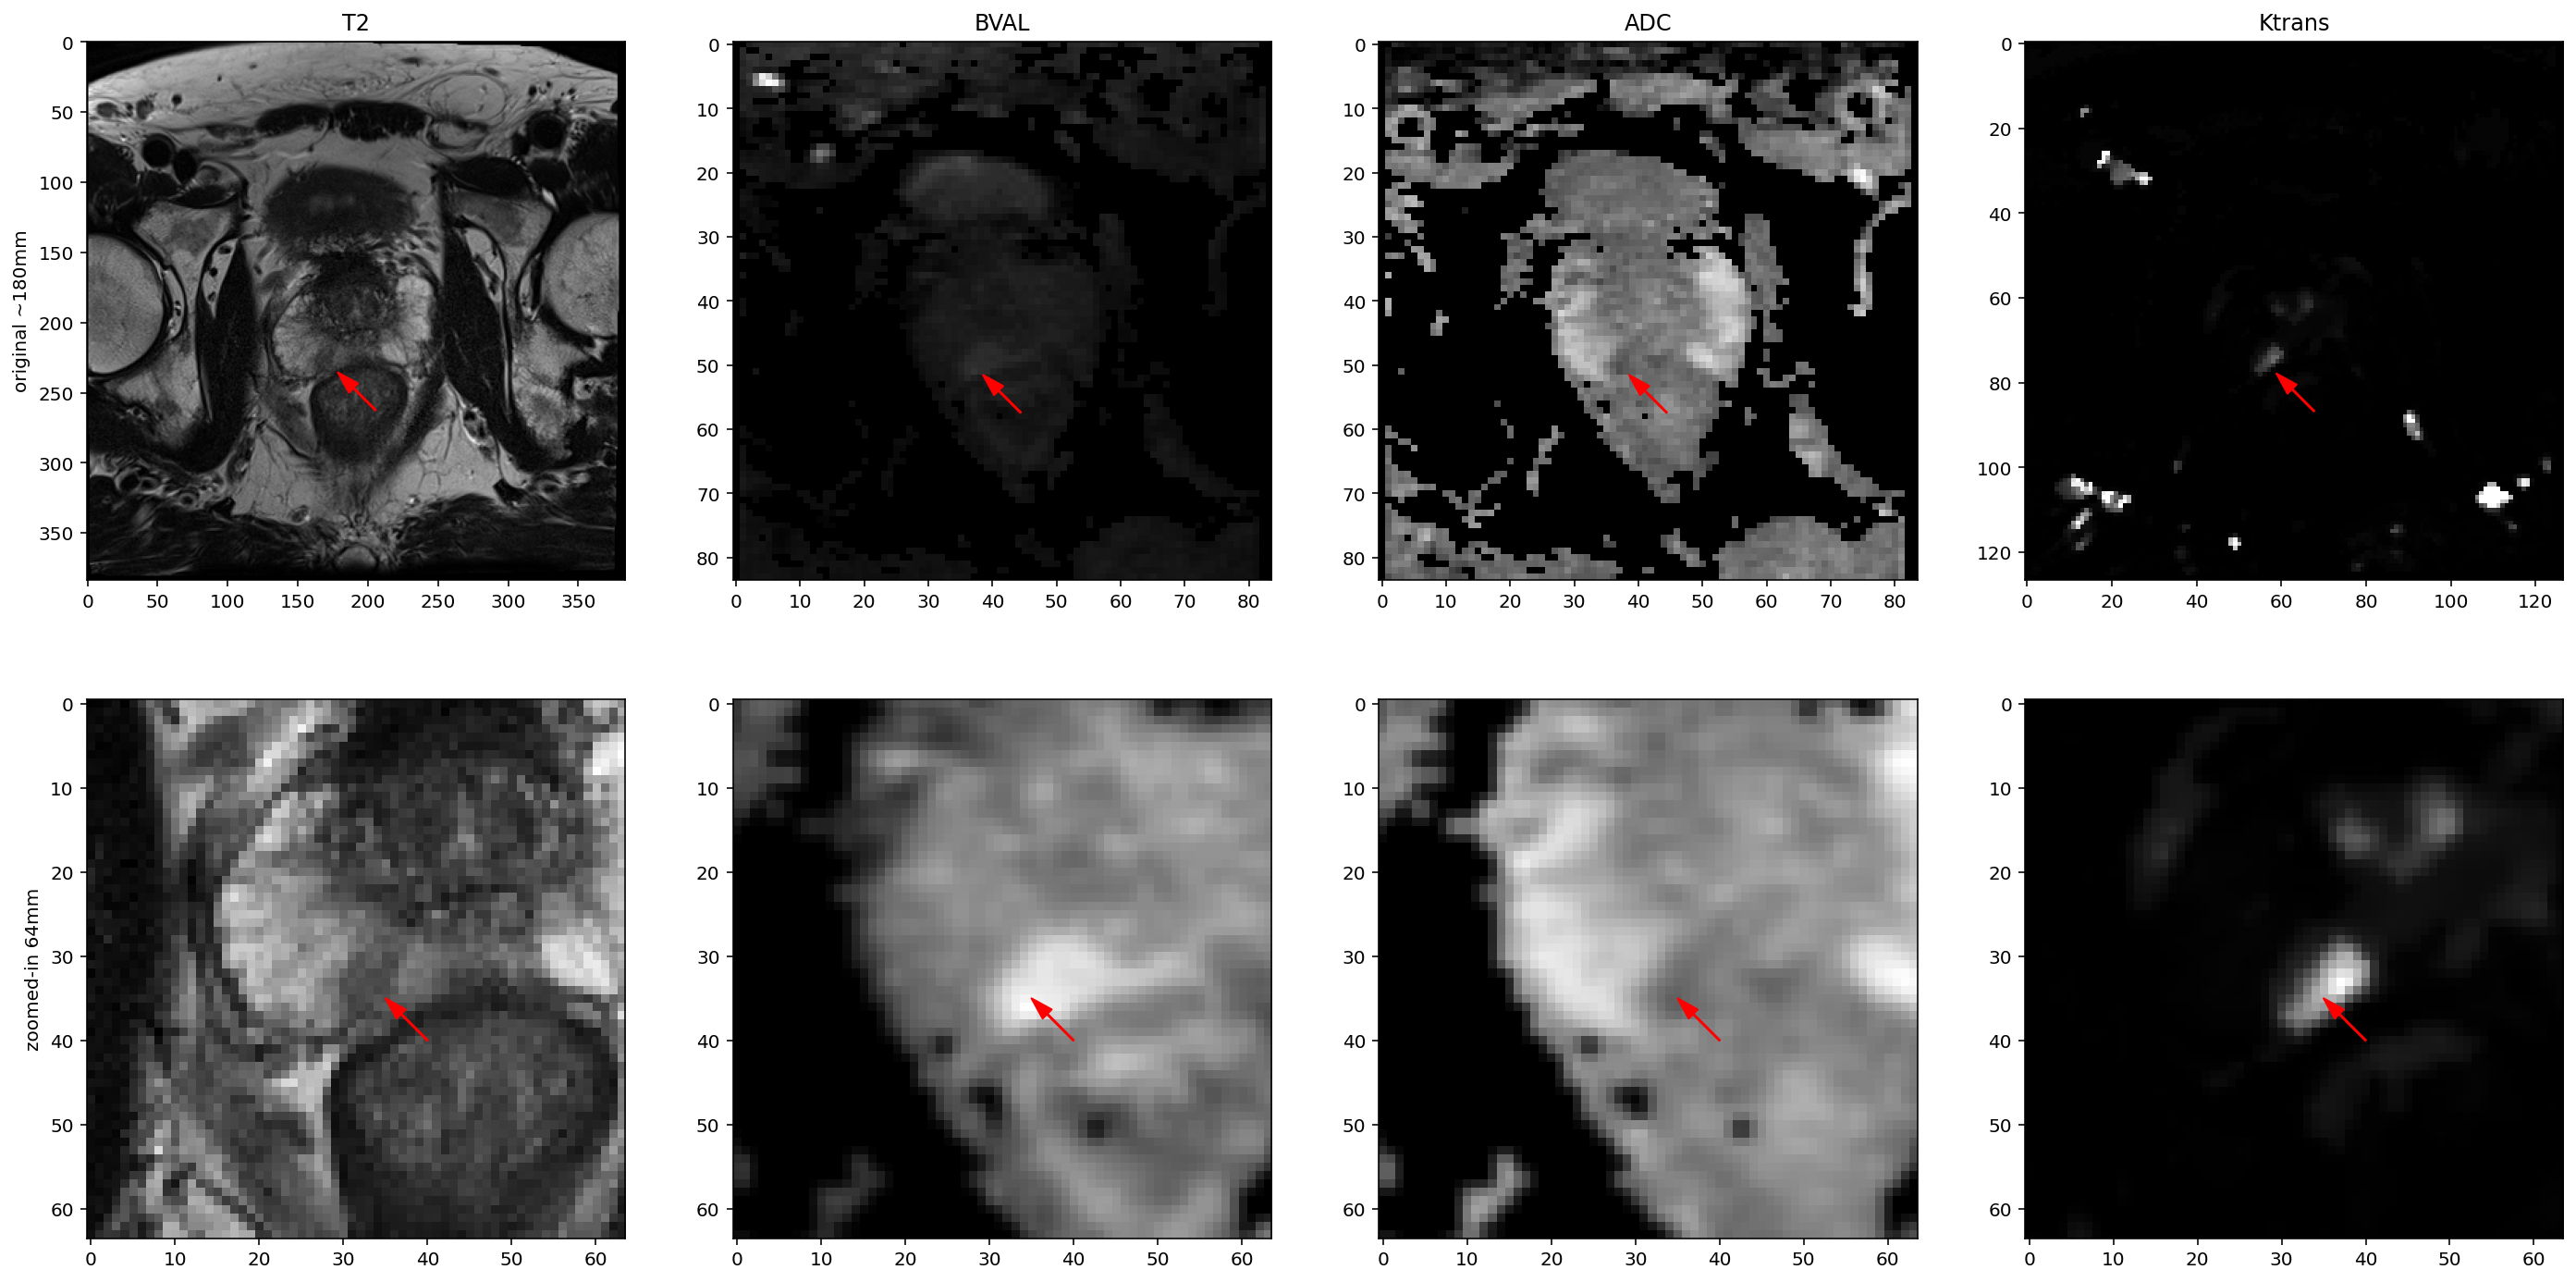

In [5]:
fig = get_vis(rfindings, findings, '0000-1')
fig.show()

## Protodash

In [48]:
explainer = ProtodashExplainer()
e_score, e_index, _ = explainer.explain(embeds, embeds, m=10)
i_score, i_index, _ = explainer.explain(inputs, inputs, m=10)
p_score, p_index, _ = explainer.explain(preds, preds, m=10)
fids[e_index], fids[i_index], fids[p_index], labels[e_index], labels[i_index], labels[p_index]

/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


(array(['0139-1', '0169-1', '0038-1', '0034-1', '0084-1', '0202-2',
        '0055-1', '0006-2', '0038-3', '0118-1'], dtype='<U6'),
 array(['0066-1', '0007-1', '0172-2', '0003-1', '0088-1', '0172-1',
        '0123-1', '0187-2', '0017-1', '0184-2'], dtype='<U6'),
 array(['0083-1', '0082-1', '0172-1', '0172-4', '0062-1', '0165-1',
        '0117-3', '0178-1', '0153-1', '0184-2'], dtype='<U6'),
 array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1]),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1]))

In [60]:
pca = PCA(n_components=50, random_state=0)
tsne = TSNE(n_components=2, random_state=0)
e_vis = tsne.fit_transform(pca.fit_transform(embeds))
i_vis = tsne.fit_transform(pca.fit_transform(inputs))
p_vis = tsne.fit_transform(preds)

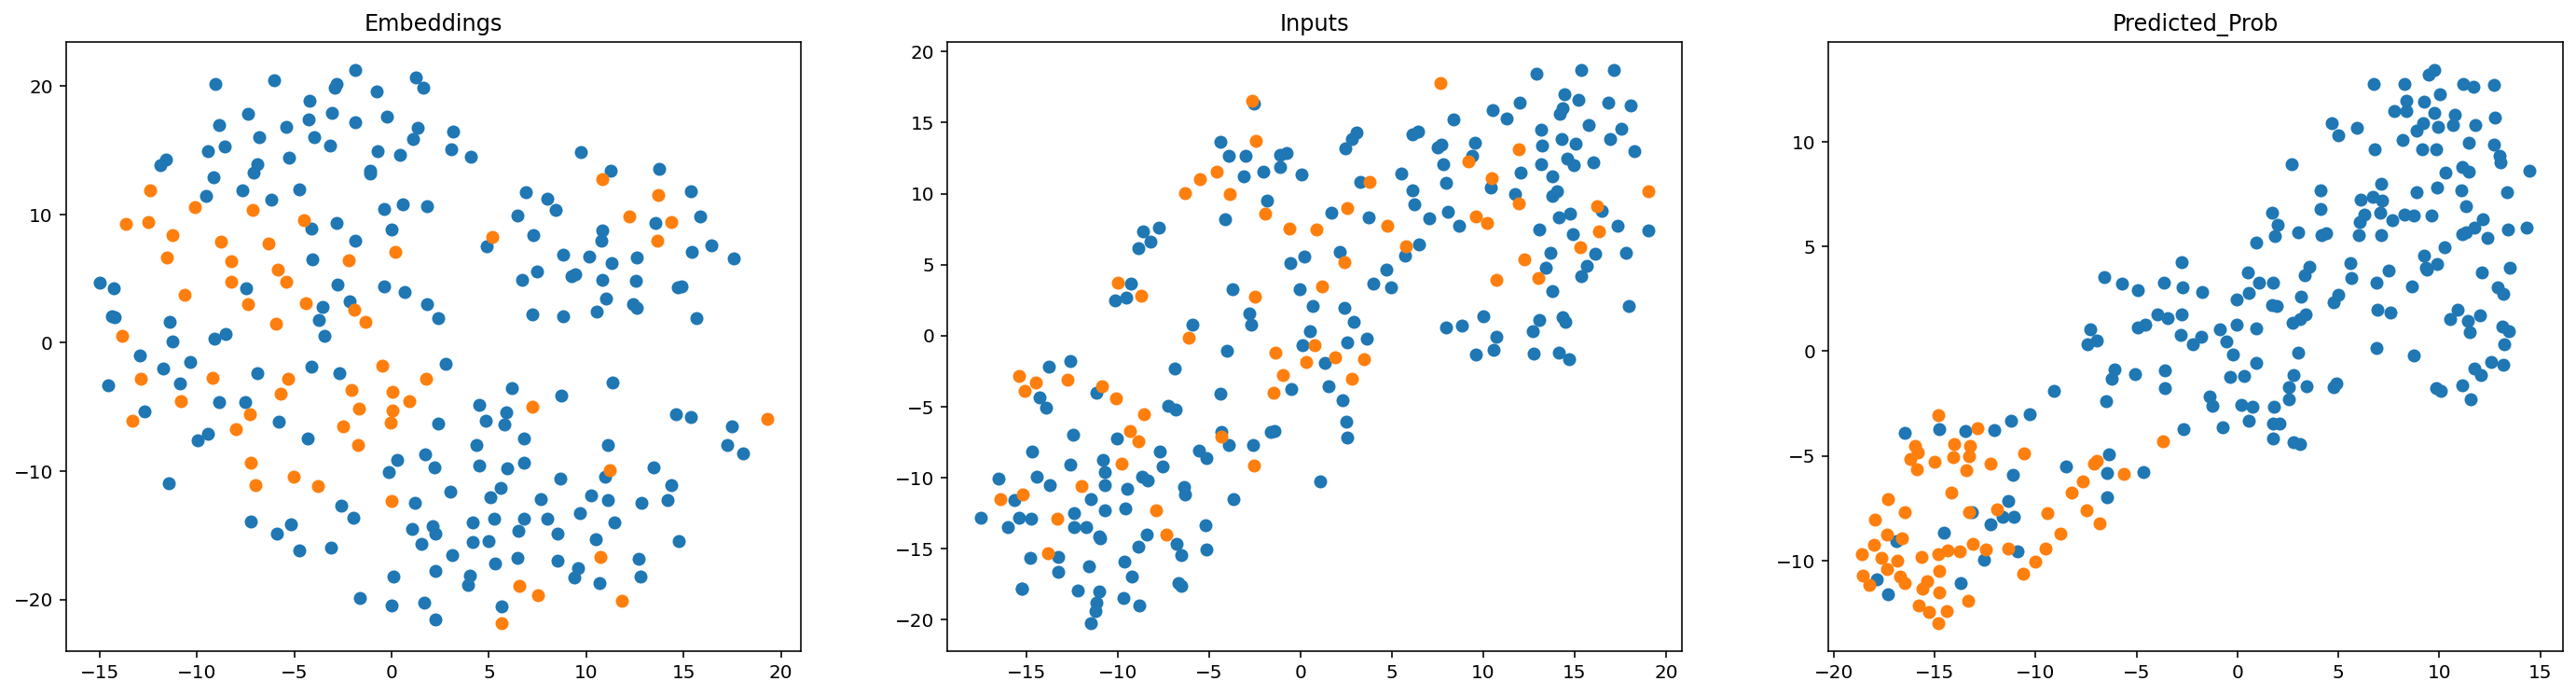

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
for i, tup in enumerate([(e_vis, e_index), (i_vis, i_index), (p_vis, p_index)]):
    vis, index = tup
    neg = vis[labels == 0]
    pos = vis[labels == 1]
    neg_proto = vis[index][labels[index] == 0]
    pos_proto = vis[index][labels[index] == 1]
    ax[i].scatter(neg[:,0], neg[:,1])    
    ax[i].scatter(pos[:,0], pos[:,1])
    # ax[i].scatter(neg_proto[:,0], neg_proto[:,1], s=300, c='C0', marker='^')    
    # ax[i].scatter(pos_proto[:,0], pos_proto[:,1], s=300, c='C1', marker='^')
    # ax[i].scatter(neg_proto[:,0], neg_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
    # ax[i].scatter(pos_proto[:,0], pos_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
    ax[i].set_title(['Embeddings', 'Inputs', 'Predicted_Prob'][i])


In [8]:
neg_id = np.where(labels==0)[0]
pos_id = np.where(labels==1)[0]

In [10]:
explainer = ProtodashExplainer()
_, e_neg_index, _ = explainer.explain(embeds[neg_id], embeds[neg_id], m=5)
_, e_pos_index, _ = explainer.explain(embeds[pos_id], embeds[pos_id], m=5)
_, i_neg_index, _ = explainer.explain(inputs[neg_id], inputs[neg_id], m=5)
_, i_pos_index, _ = explainer.explain(inputs[pos_id], inputs[pos_id], m=5)
_, p_neg_index, _ = explainer.explain(preds[neg_id], preds[neg_id], m=5)
_, p_pos_index, _ = explainer.explain(preds[pos_id], preds[pos_id], m=5)

/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


In [11]:
fids[neg_id[e_neg_index]], fids[pos_id[e_pos_index]]

(array(['0139-2', '0153-3', '0145-1', '0042-1', '0023-1'], dtype='<U6'),
 array(['0139-1', '0169-1', '0164-1', '0054-1', '0077-1'], dtype='<U6'))

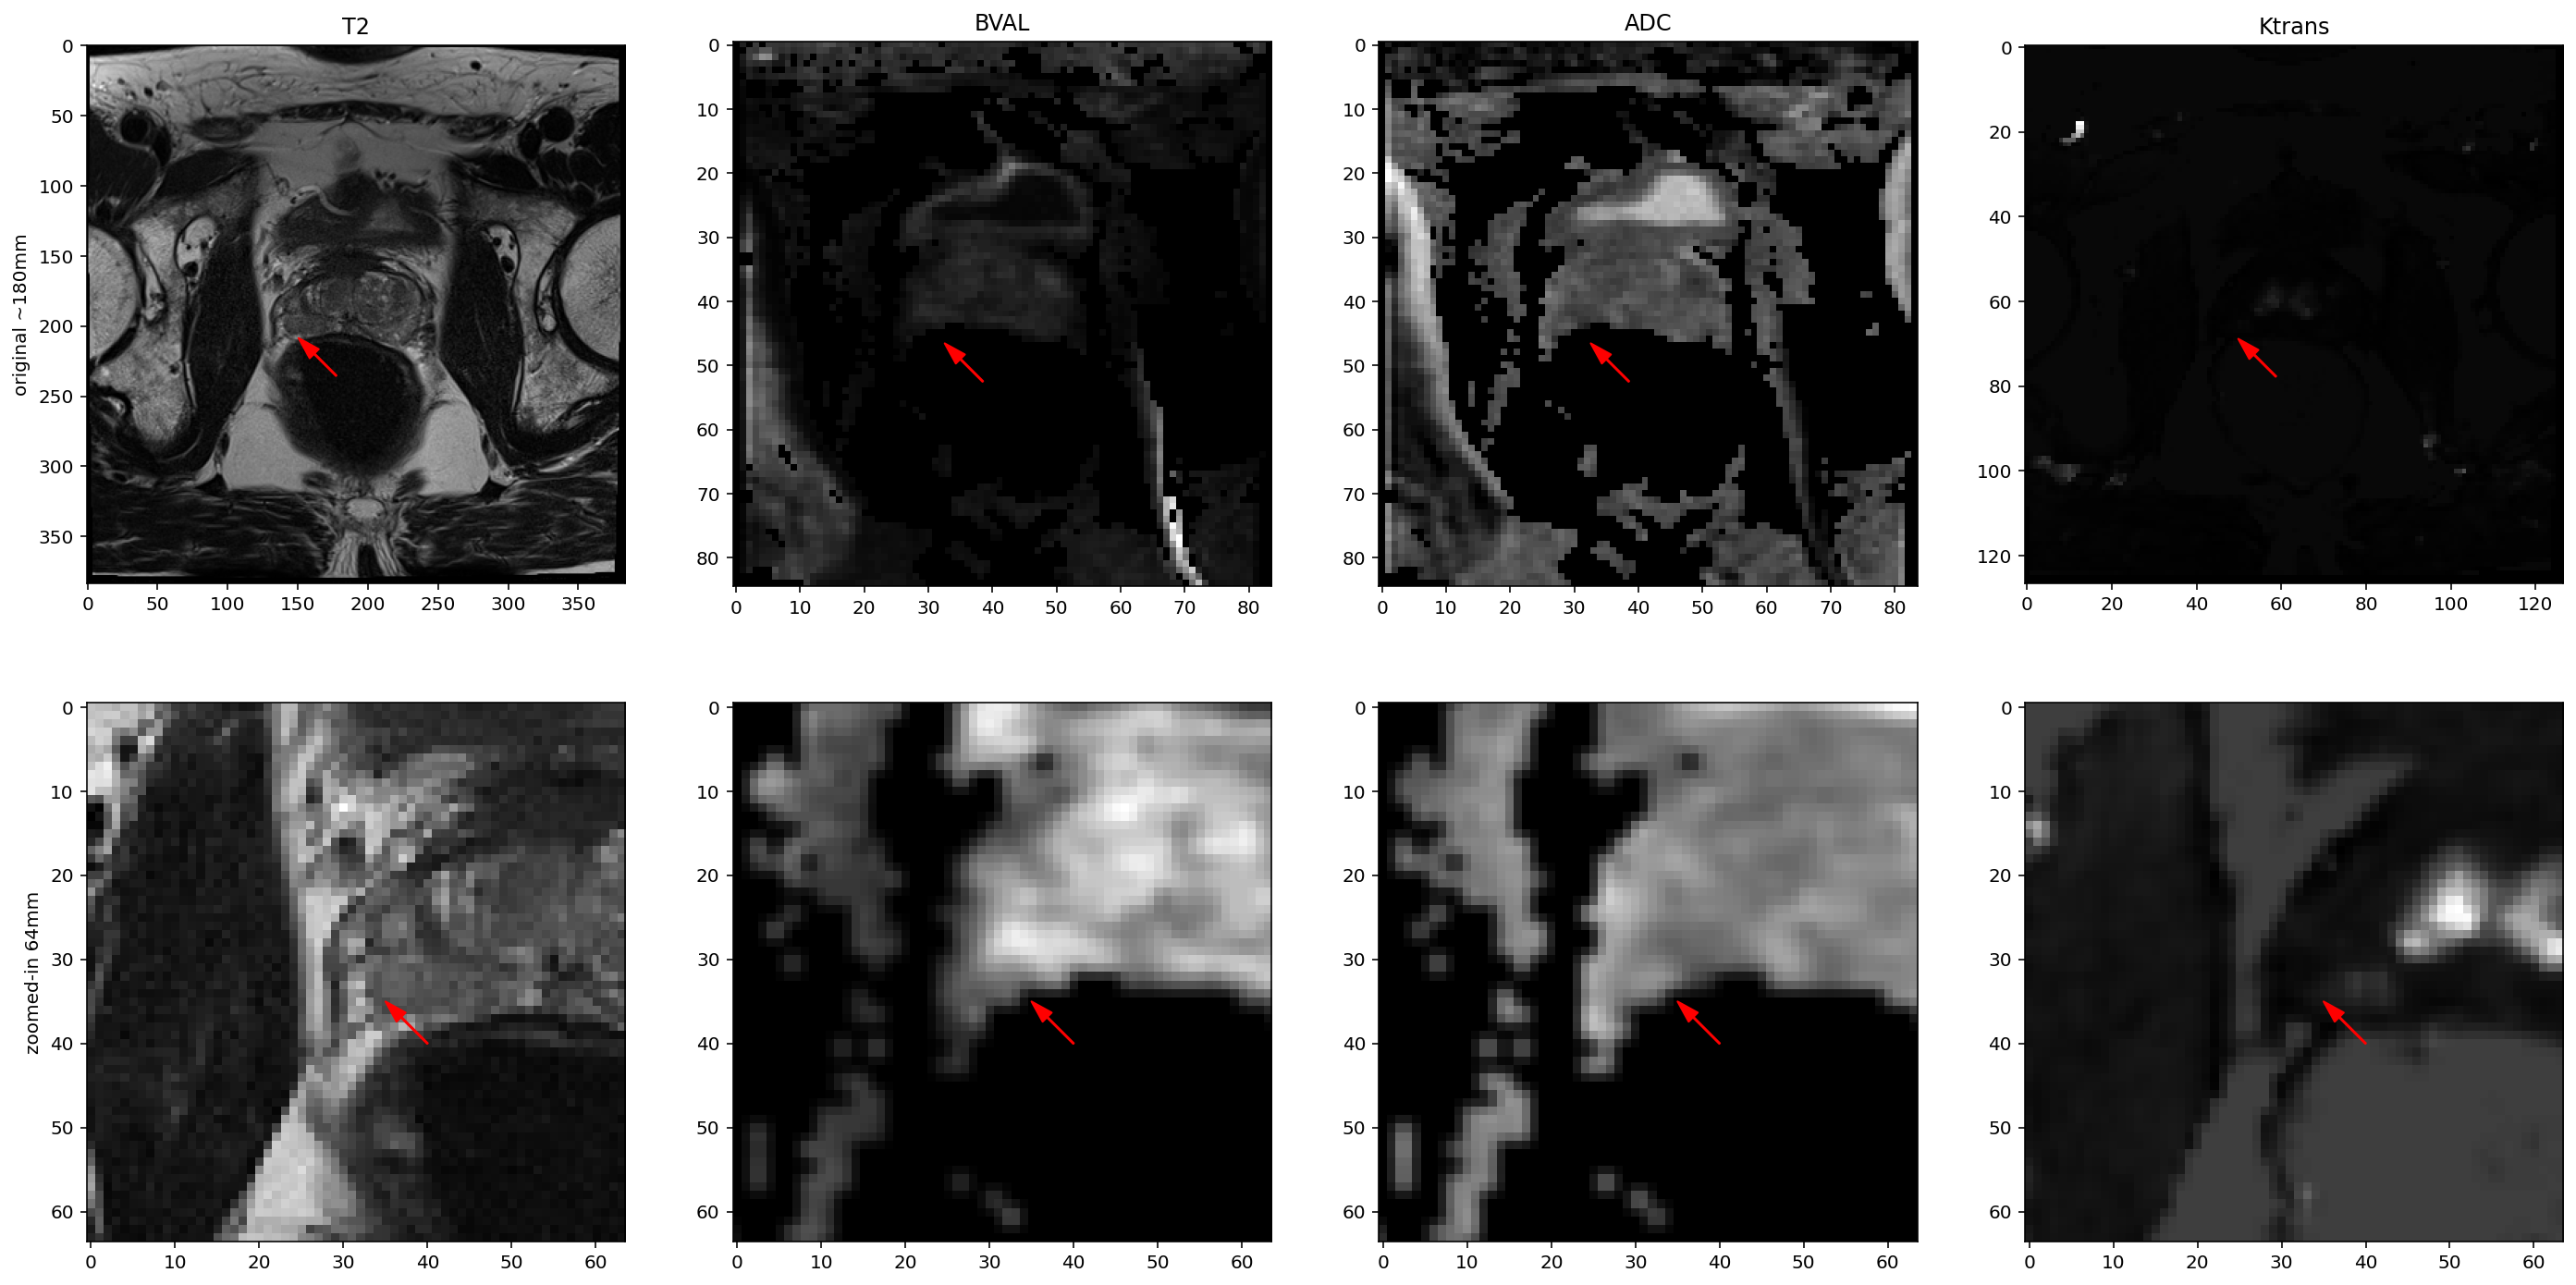

In [12]:
fig = get_vis(rfindings, findings, fids[neg_id[e_neg_index]][4])
# fig = get_vis(rfindings, findings, fids[pos_id[e_pos_index]][4])
fig.show()

In [13]:
fids[pos_id[e_pos_index]][0], neg_id[e_neg_index[0]]

('0139-1', 126)

In [14]:
e_index = (neg_id[e_neg_index], pos_id[e_pos_index])
i_index = (neg_id[i_neg_index], pos_id[i_pos_index])
p_index = (neg_id[p_neg_index], pos_id[p_pos_index])

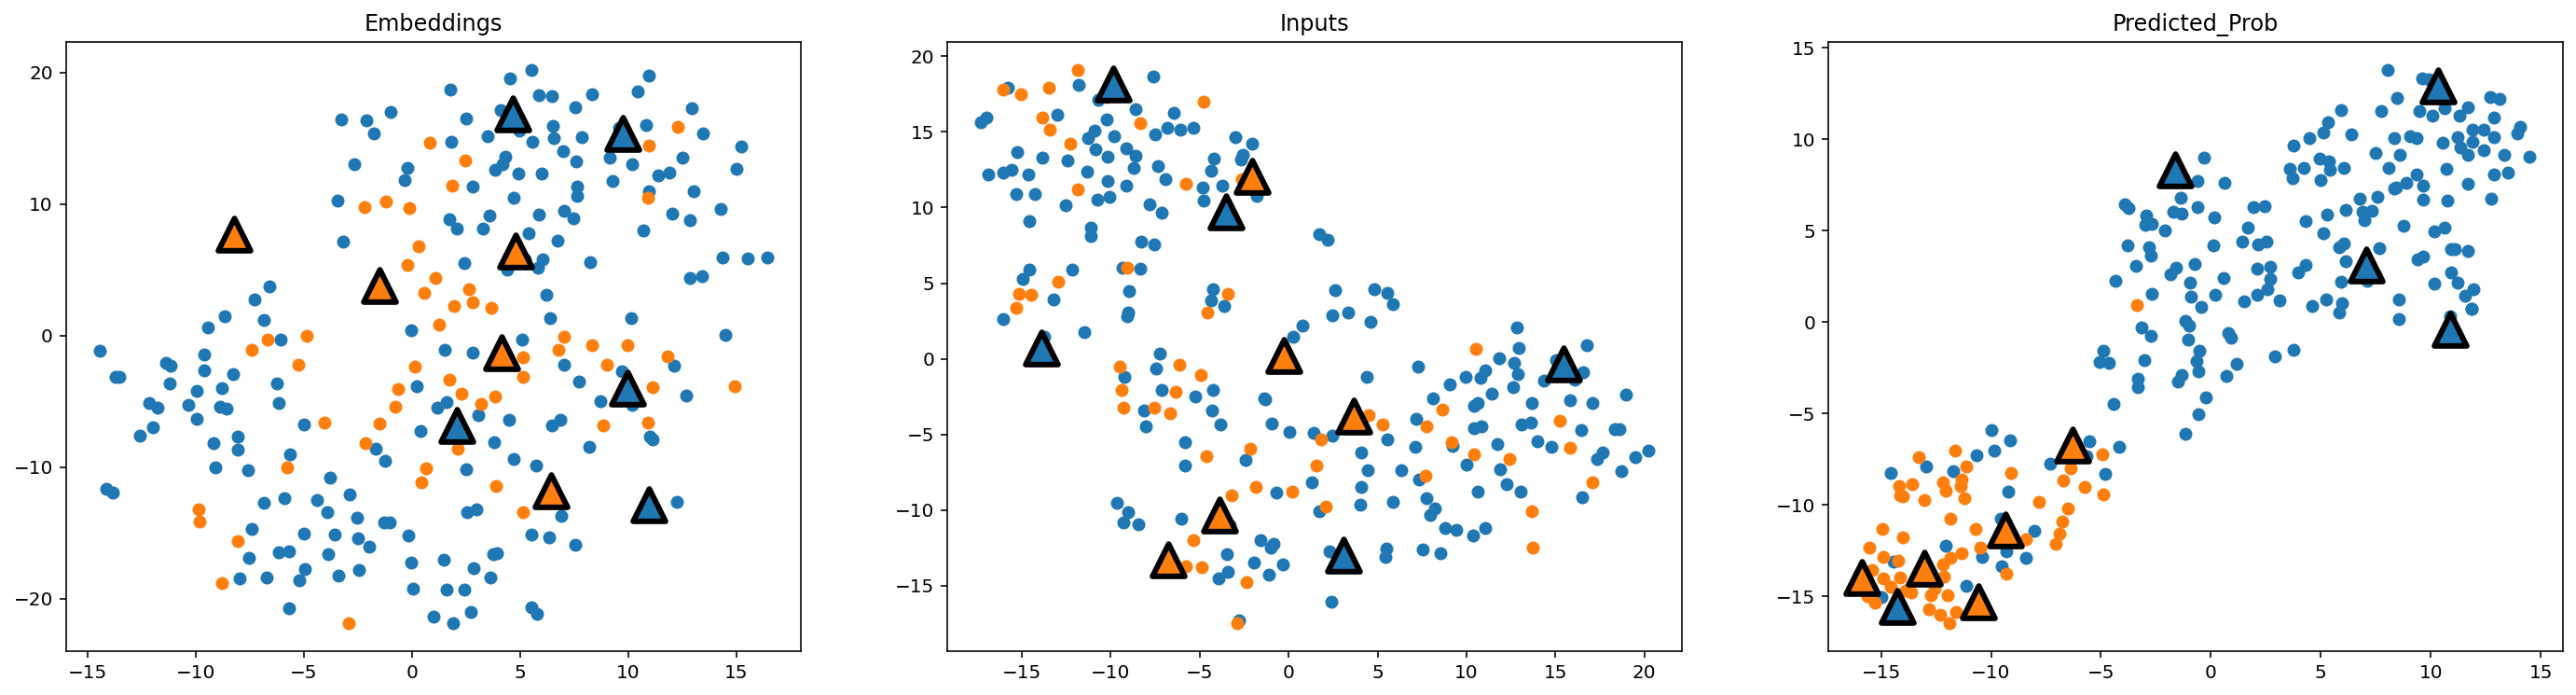

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
for i, tup in enumerate([(e_vis, e_index), (i_vis, i_index), (p_vis, p_index)]):
    vis, index = tup
    neg = vis[labels == 0]
    pos = vis[labels == 1]
    neg_index, pos_index = index
    neg_proto = vis[neg_index]
    pos_proto = vis[pos_index]
    ax[i].scatter(neg[:,0], neg[:,1])    
    ax[i].scatter(pos[:,0], pos[:,1])
    ax[i].scatter(neg_proto[:,0], neg_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
    ax[i].scatter(pos_proto[:,0], pos_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
    ax[i].set_title(['Embeddings', 'Inputs', 'Predicted_Prob'][i])


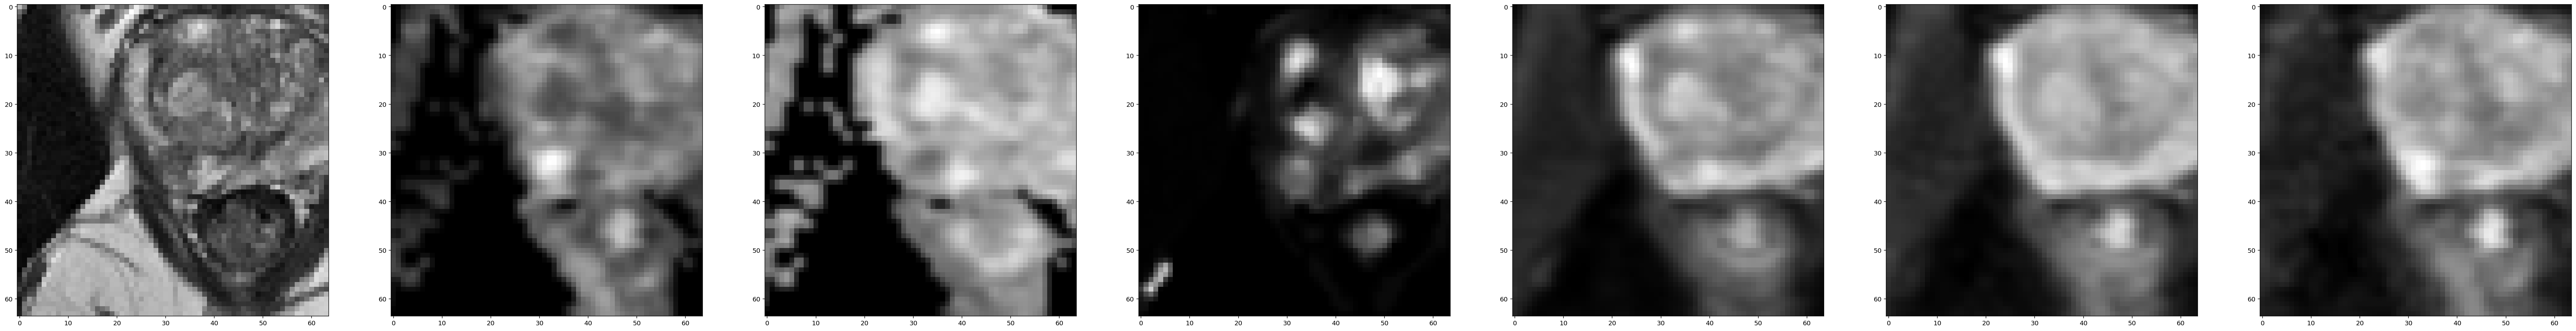

In [16]:
dataset = torchvision.datasets.DatasetFolder('tbakd3_npy/uint8/5folds/4/train_bal', extensions='npy', loader=np.load, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), drop_last=False, shuffle=False)
fig, ax = plt.subplots(1, 7, figsize=(72, 72))
for i in range(7):
    ax[i].imshow(dataset[126][0][i], cmap='gray')

In [9]:
pz_id = np.array([i for i in range(len(fids)) if findings[fids[i]]['zone'] == b'PZ'])
tz_id = np.array([i for i in range(len(fids)) if findings[fids[i]]['zone'] == b'TZ'])

In [10]:
pz_pos = np.array([i for i in pz_id if i in pos_id])
pz_neg = np.array([i for i in pz_id if i in neg_id])

In [63]:
nid, pid = pz_neg, pz_pos
explainer = ProtodashExplainer()
_, e_neg_index, _ = explainer.explain(embeds[nid], embeds[nid], m=5)
_, e_pos_index, _ = explainer.explain(embeds[pid], embeds[pid], m=5)
_, i_neg_index, _ = explainer.explain(inputs[nid], inputs[nid], m=5)
_, i_pos_index, _ = explainer.explain(inputs[pid], inputs[pid], m=5)
_, p_neg_index, _ = explainer.explain(preds[nid], preds[nid], m=5)
_, p_pos_index, _ = explainer.explain(preds[pid], preds[pid], m=5)

/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


In [64]:
fids[pz_neg[p_neg_index]], fids[pz_pos[p_pos_index]]

(array(['0135-2', '0165-1', '0063-1', '0050-1', '0156-1'], dtype='<U6'),
 array(['0195-1', '0040-1', '0117-1', '0031-1', '0041-1'], dtype='<U6'))

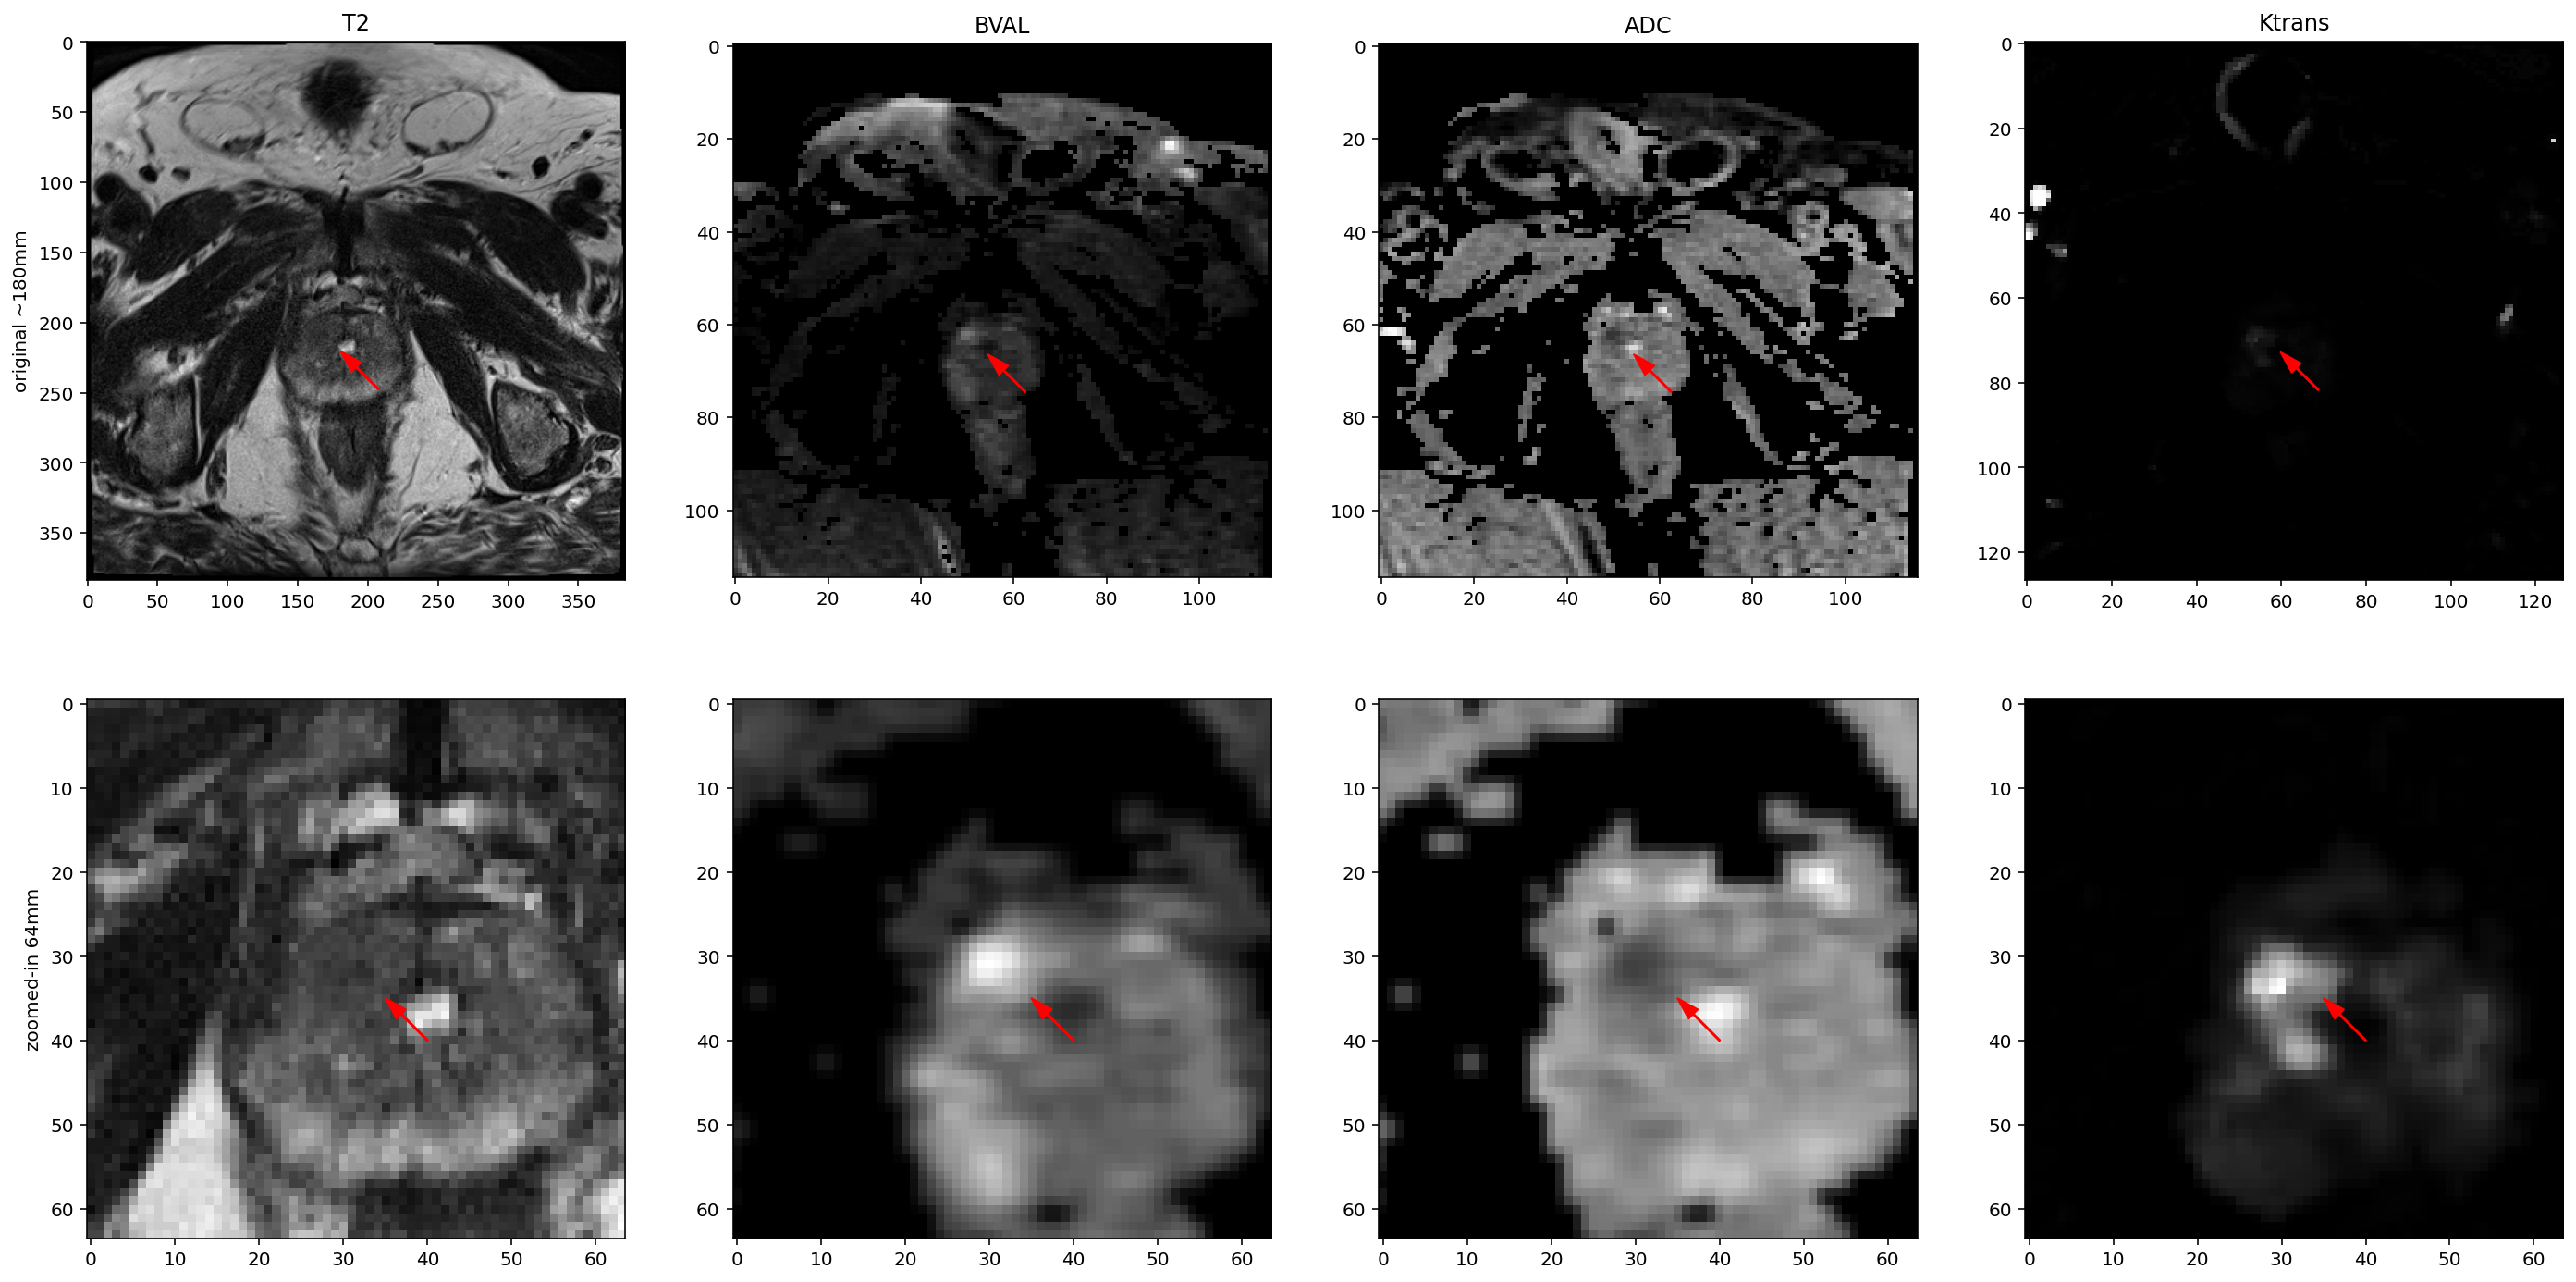

In [13]:
fig = get_vis(rfindings, findings, fids[pz_pos[p_pos_index]][0])
fig.show()

In [65]:
e_index = (pz_neg[e_neg_index], pz_pos[e_pos_index])
i_index = (pz_neg[i_neg_index], pz_pos[i_pos_index])
p_index = (pz_neg[p_neg_index], pz_pos[p_pos_index])

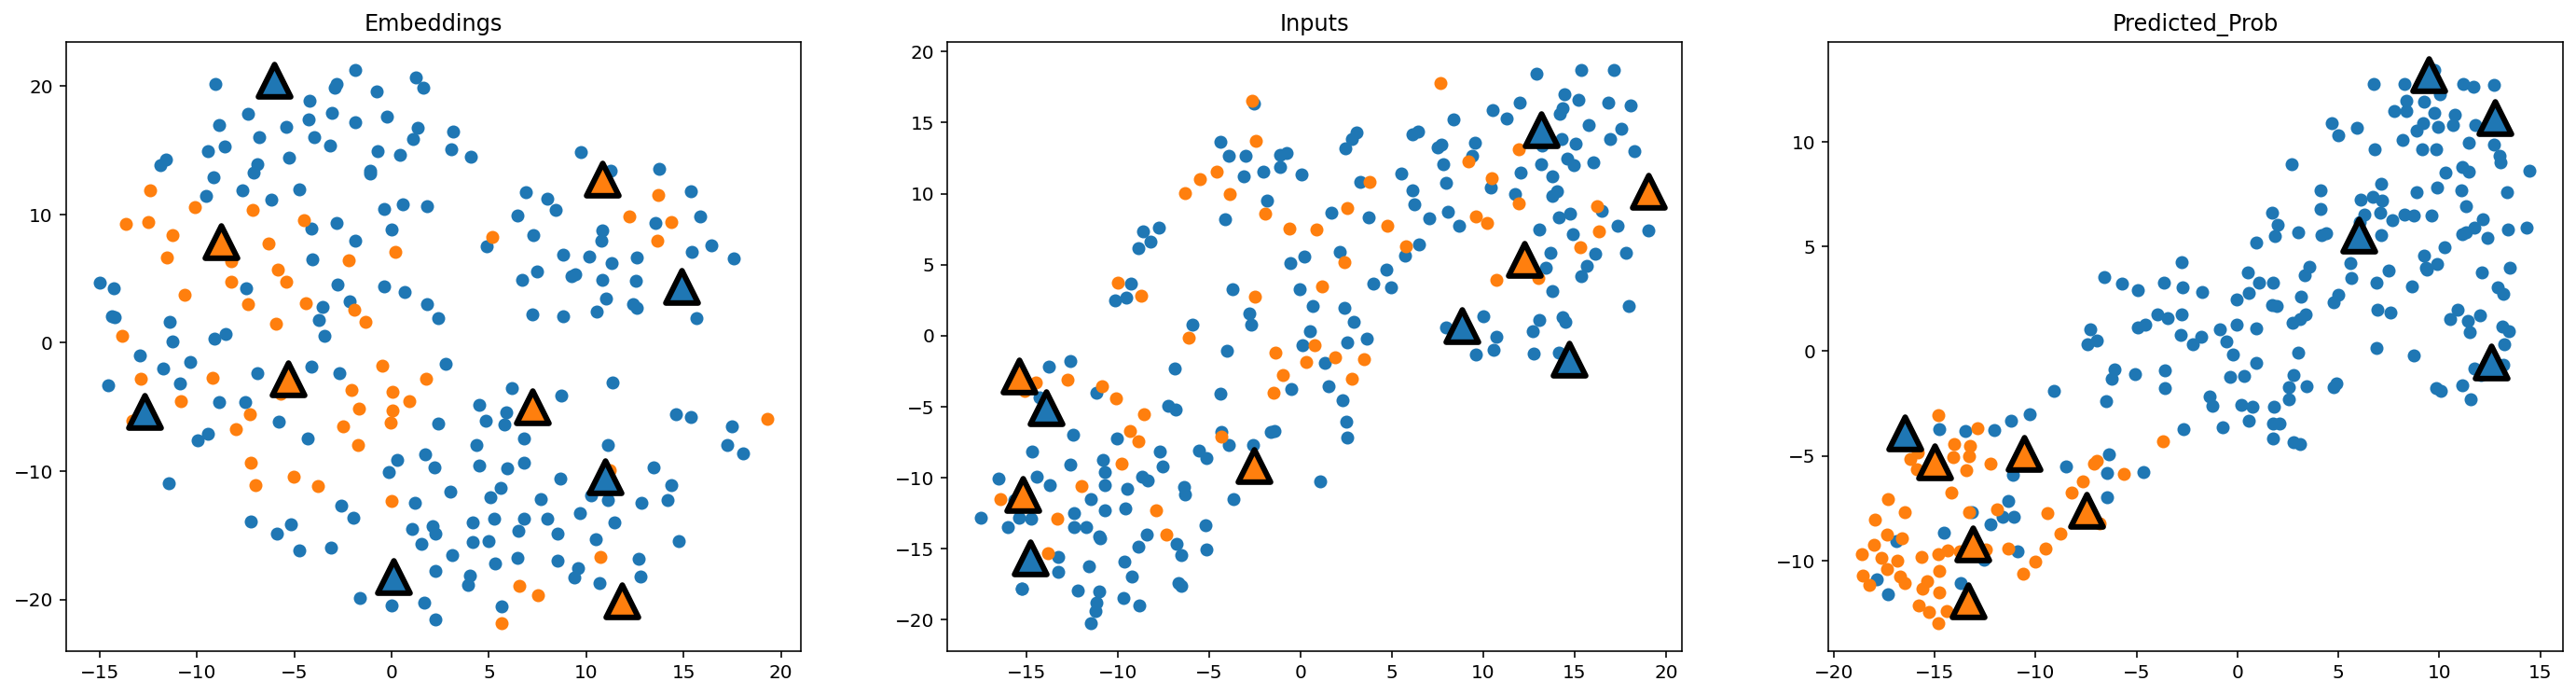

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
for i, tup in enumerate([(e_vis, e_index), (i_vis, i_index), (p_vis, p_index)]):
    vis, index = tup
    neg = vis[labels == 0]
    pos = vis[labels == 1]
    neg_index, pos_index = index
    neg_proto = vis[neg_index]
    pos_proto = vis[pos_index]
    ax[i].scatter(neg[:,0], neg[:,1])    
    ax[i].scatter(pos[:,0], pos[:,1])
    ax[i].scatter(neg_proto[:,0], neg_proto[:,1], s=300, c='C0', marker='^', linewidths=3, edgecolors='k')    
    ax[i].scatter(pos_proto[:,0], pos_proto[:,1], s=300, c='C1', marker='^', linewidths=3, edgecolors='k')
    ax[i].set_title(['Embeddings', 'Inputs', 'Predicted_Prob'][i])


In [67]:
neg_proto

array([[  6.0012484 ,   5.5558867 ],
       [-16.46435   ,  -3.8821983 ],
       [ 12.734754  ,  11.133231  ],
       [ 12.575524  ,  -0.51469177],
       [  9.462281  ,  13.208007  ]], dtype=float32)

In [16]:
preds[p_index[0]] @ w_e, preds[p_index[1]] @ w_e

(array([0.34990147, 0.74909985, 0.2725731 , 0.3546043 , 0.22464943],
       dtype=float32),
 array([0.71415675, 0.630159  , 0.8118305 , 0.60615516, 0.7455933 ],
       dtype=float32))

In [42]:
y_pred = preds @ w_e > 0.5
y_true = np.zeros(len(y_pred))
y_true[pos_id] += 1

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
confusion_matrix(y_true, y_pred)

array([[152,  44],
       [  1,  59]])

## K-Medoids

## Contrastive

In [82]:
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import argparse
args = argparse.Namespace(mri_sequences='ABDEFKT', data_sequences='TBAKDEF', pooling=True)
ckpt = 'results/wang-f32-vl-all/1819rnv8/checkpoints/best_model.ckpt'
from wang_args import WangClassifier
model = WangClassifier.load_from_checkpoint(ckpt, **vars(args))
_ = model.eval()

In [6]:
from aix360.algorithms.contrastive import CEMExplainer

Using TensorFlow backend.


In [15]:
pos_id[e_pos_index]

array([233, 236, 235, 208, 211])

In [18]:
image_id = 233
input_image = dataset[126][0]

In [ ]:
class CEMClassfier():

    def __init__(self, model):
        self._model = model
        self._nb_classes = 2
        # self._input_shape = model.input_shape

    def predict(self, x):
        return self._model.predict(x)

    def predict_long(self, x):
        logits = self.predict(x)
        predicted_class = torch.argmax(logits).item()
        logits_np = logits.detach().cpu().numpy()
        logits_str = np.array2string(logits_np).replace('\n','')
        return(logits_np, predicted_class, logits_str)

    def predictsym(self, x):
        # t = torch.from_numpy(x)
        x = tf.Session().run(x)
        print(x.shape, type(x))
        return self._model.predict(x)

In [85]:
clf = CEMClassfier(model)
explainer = CEMExplainer(clf)
arg_mode = "PN" # Find pertinent negative

arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term

arg_kappa = 0.9 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1.0 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) autoencoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 0.05 # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5

(adv_pn, delta_pn, info_pn) = explainer.explain_instance(input_image[np.newaxis,:], arg_mode, None, arg_kappa, arg_b, 
                                            arg_max_iter, arg_init_const, arg_beta, arg_gamma, arg_alpha, arg_threshold, arg_offset)

FailedPreconditionError: Attempting to use uninitialized value Variable_61
	 [[node Variable_61/read (defined at /net/scratch/hanliu/radiology/AIX360/aix360/algorithms/contrastive/CEM_aen.py:53) ]]

Original stack trace for 'Variable_61/read':
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-85-670a6630e9db>", line 18, in <module>
    arg_max_iter, arg_init_const, arg_beta, arg_gamma, arg_alpha, arg_threshold, arg_offset)
  File "/net/scratch/hanliu/radiology/AIX360/aix360/algorithms/contrastive/CEM.py", line 93, in explain_instance
    alpha=arg_alpha, threshold=arg_threshold, offset=arg_offset)
  File "/net/scratch/hanliu/radiology/AIX360/aix360/algorithms/contrastive/CEM_aen.py", line 53, in __init__
    self.adv_img = tf.Variable(np.zeros(shape), dtype=tf.float32)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1755, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 86, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4253, in identity
    "Identity", input=input, name=name)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/hanliu/anaconda3/envs/aix360/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
